Import Libraries and Load Data

In [5]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

file_path = "/Users/ridhi/Desktop/primary data.csv"
df = pd.read_csv(file_path)

print(df.head())

   Sno  X  State       conversation_id  retweet_count  reply_count  \
0    1  1  Assam  S1438213588544409600              0            1   
1    2  2  Assam  S1438437895270846464              0            1   
2    3  3  Assam  S1439558164936941574              0            1   
3    4  4  Assam  S1439920409801945089              0            1   
4    5  5  Assam  S1440221445011898371              0            1   

   like_count  quote_count  Buzz                    id  ...    i we.1 they  \
0           1            0     3  S1438213588544409600  ...  0.0  0.0  0.0   
1           1            0     3  S1438437895270846464  ...  0.0  0.0  0.0   
2           1            0     3  S1439558164936941574  ...  0.0  0.0  0.0   
3           3            0     5  S1439920409801945089  ...  0.0  0.0  0.0   
4           1            0     3  S1440221445011898371  ...  0.0  0.0  0.0   

  insight cause discrep certitude  Positive Negative Total_Sentiment  
0    3.23   0.0    0.00       0.0      

Bronze Layer - Save Raw Data

In [23]:
# Connect to SQLite database (or create it if it doesn't exist)
bronze_connection = sqlite3.connect("bronze_layer.db")
cursor = bronze_connection.cursor()

# Save the data to the Bronze layer without modifications
df.to_sql("tweets_bronze", bronze_connection, if_exists="replace", index=False)

# Commit the database
bronze_connection.commit()
print("Data successfully saved to the Bronze layer.")

Data successfully saved to the Bronze layer.


Basic Bronze Layer Queries

In [24]:
# Query 1: Count the total number of rows in the Bronze layer
query_1 = "SELECT COUNT(*) AS total_records FROM tweets_bronze;"
df_query_1 = pd.read_sql_query(query_1, bronze_connection)
print("Total records in Bronze layer:\n", df_query_1)

# Query 2: Get the unique states in the dataset to understand the distribution
query_2 = "SELECT DISTINCT State FROM tweets_bronze;"
df_query_2 = pd.read_sql_query(query_2, bronze_connection)
print("Unique states in the dataset:\n", df_query_2)

# Query 3: Retrieve the first few rows of the raw data
query_3 = "SELECT * FROM tweets_bronze LIMIT 5;"
df_query_3 = pd.read_sql_query(query_3, bronze_connection)
print("First few rows of raw data:\n", df_query_3)

Total records in Bronze layer:
    total_records
0          23006
Unique states in the dataset:
           State
0         Assam
1         Bihar
2   Chattisgarh
3         Delhi
4           Goa
5       Gujarat
6            HP
7       J and K
8     Jharkhand
9     Karnataka
10       Kerala
11  Maharashtra
12      Mizoram
13           MP
14     Nagaland
15       Odisha
16    Rajasthan
17    Tamilnadu
18    Telangana
19      Tripura
20           UP
21   Uttarkhand
22   WestBengal
First few rows of raw data:
    Sno  X  State       conversation_id  retweet_count  reply_count  \
0    1  1  Assam  S1438213588544409600              0            1   
1    2  2  Assam  S1438437895270846464              0            1   
2    3  3  Assam  S1439558164936941574              0            1   
3    4  4  Assam  S1439920409801945089              0            1   
4    5  5  Assam  S1440221445011898371              0            1   

   like_count  quote_count  Buzz                    id  ...    i we.1

 Data Cleaning (Silver Layer)

In [4]:
# 1. Handle Missing Values
df['like_count'].fillna(0, inplace=True)
df['retweet_count'].fillna(0, inplace=True)
df['reply_count'].fillna(0, inplace=True)
df['quote_count'].fillna(0, inplace=True)

# 2. Standardize Date and Time Formats
df['Date1'] = pd.to_datetime(df['Date1'], format='%d-%m-%Y', errors='coerce')

# 3. Feature Engineering
# Total engagement
df['total_engagement'] = df['like_count'] + df['retweet_count'] + df['reply_count'] + df['quote_count']

# Sentiment score
df['sentiment_score'] = df['Positive'] - df['Negative']

# Classify time of day
df['time_of_day'] = df['OpnHours'].apply(lambda x: 'Business hours' if 'Working' in x else 'Non-business hours')

# Classify day type
df['day_type'] = df['Day'].apply(lambda x: 'Weekend' if x in ['Saturday', 'Sunday'] else 'Weekday')

# Save the cleaned and structured data to a new SQLite database as Silver Layer
silver_connection = sqlite3.connect("silver_layer.db")
df.to_sql("tweets_silver", silver_connection, if_exists="replace", index=False)

# Commit the Silver layer database
silver_connection.commit()
print("Data successfully saved to the Silver layer.")

Data successfully saved to the Silver layer.


Silver Layer Analysis Queries

In [5]:
# Query 1: Average total engagement by day type (weekday vs. weekend)
query_1 = "SELECT day_type, AVG(total_engagement) AS avg_engagement FROM tweets_silver GROUP BY day_type;"
df_query_1 = pd.read_sql_query(query_1, silver_connection)
print("Average engagement by day type:\n", df_query_1)

# Query 2: Average sentiment score by time of day (business vs. non-business hours)
query_2 = "SELECT time_of_day, AVG(sentiment_score) AS avg_sentiment FROM tweets_silver GROUP BY time_of_day;"
df_query_2 = pd.read_sql_query(query_2, silver_connection)
print("Average sentiment by time of day:\n", df_query_2)

# Query 3: Top 5 states by average total engagement
query_3 = "SELECT State, AVG(total_engagement) AS avg_engagement FROM tweets_silver GROUP BY State ORDER BY avg_engagement DESC LIMIT 5;"
df_query_3 = pd.read_sql_query(query_3, silver_connection)
print("Top 5 states by average engagement:\n", df_query_3)

Average engagement by day type:
   day_type  avg_engagement
0  Weekday      163.422194
Average sentiment by time of day:
           time_of_day  avg_sentiment
0      Business hours       2.313608
1  Non-business hours       2.342935
Top 5 states by average engagement:
          State  avg_engagement
0           MP      555.456000
1       Kerala      522.971406
2        Bihar      249.127148
3  Maharashtra      238.679260
4      Gujarat      220.780666



Aggregations and Enrichments for Gold Layer

In [6]:
# 1. Average engagement and sentiment by phase (3-Phase)
phase_engagement = df.groupby("3-Phase").agg(
    avg_engagement=("total_engagement", "mean"),
    avg_sentiment=("sentiment_score", "mean")
).reset_index()

# 2. Average engagement by content type
content_engagement = df.groupby("ContentType").agg(
    avg_engagement=("total_engagement", "mean")
).reset_index()

# 3. Rank states by average engagement
state_engagement = df.groupby("State").agg(
    avg_engagement=("total_engagement", "mean")
).reset_index().sort_values(by="avg_engagement", ascending=False)

# Save these aggregated tables to the Gold layer
gold_connection = sqlite3.connect("gold_layer.db")
phase_engagement.to_sql("phase_engagement", gold_connection, if_exists="replace", index=False)
content_engagement.to_sql("content_engagement", gold_connection, if_exists="replace", index=False)
state_engagement.to_sql("state_engagement", gold_connection, if_exists="replace", index=False)

# Commit the Gold layer database
gold_connection.commit()
print("Data successfully saved to the Gold layer.")

Data successfully saved to the Gold layer.


Gold Layer Queries and Visualizations

In [7]:
# Query 1: Average engagement and sentiment by phase
query_1 = "SELECT * FROM phase_engagement;"
df_query_1 = pd.read_sql_query(query_1, gold_connection)
print("Average engagement and sentiment by phase:\n", df_query_1)

Average engagement and sentiment by phase:
           3-Phase  avg_engagement  avg_sentiment
0  Covid Lockdown      174.734554        2.30860
1   Post Lockdown      175.179392        2.22503
2       Pre-Covid      138.931193        2.46729


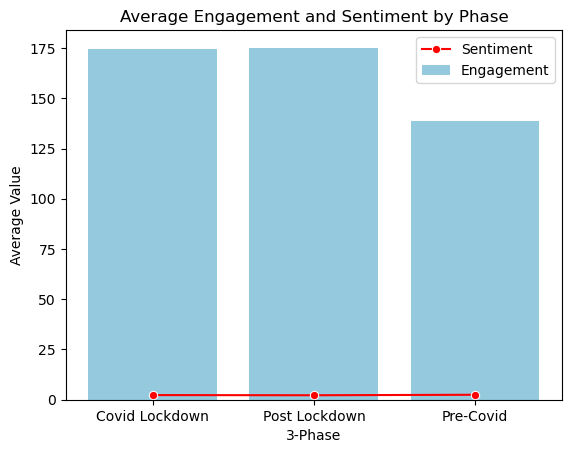

In [17]:
sns.barplot(x="3-Phase", y="avg_engagement", data=df_query_1, color="skyblue", label="Engagement")
sns.lineplot(x="3-Phase", y="avg_sentiment", data=df_query_1, color="red", marker="o", label="Sentiment")
plt.title("Average Engagement and Sentiment by Phase")
plt.ylabel("Average Value")
plt.legend()
plt.show()

In [8]:
# Query 2: Average engagement by content type
query_2 = "SELECT * FROM content_engagement ORDER BY avg_engagement DESC;"
df_query_2 = pd.read_sql_query(query_2, gold_connection)
print("Average engagement by content type:\n", df_query_2)

Average engagement by content type:
    ContentType  avg_engagement
0  Information      165.495691
1  Interaction      158.316930


/var/folders/k8/ffchd2g90sx_zj2z54hjrgf80000gn/T/ipykernel_5316/866028920.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="ContentType", y="avg_engagement", data=df_query_2, palette="viridis")


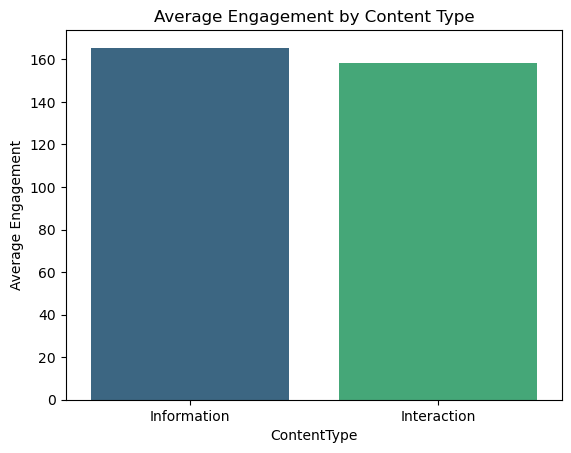

In [18]:
sns.barplot(x="ContentType", y="avg_engagement", data=df_query_2, palette="viridis")
plt.title("Average Engagement by Content Type")
plt.ylabel("Average Engagement")
plt.show()

In [9]:
# Query 3: Top 5 states by average engagement
query_3 = "SELECT * FROM state_engagement LIMIT 5;"
df_query_3 = pd.read_sql_query(query_3, gold_connection)
print("Top 5 states by average engagement:\n", df_query_3)

Top 5 states by average engagement:
          State  avg_engagement
0           MP      555.456000
1       Kerala      522.971406
2        Bihar      249.127148
3  Maharashtra      238.679260
4      Gujarat      220.780666


/var/folders/k8/ffchd2g90sx_zj2z54hjrgf80000gn/T/ipykernel_5316/122549051.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="avg_engagement", y="State", data=df_query_3, palette="coolwarm")


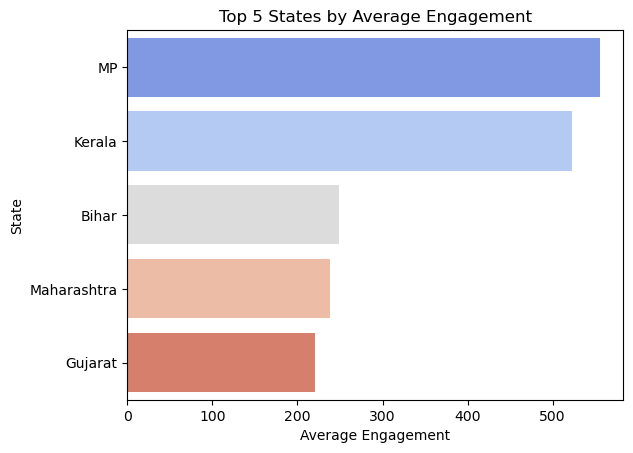

In [19]:
sns.barplot(x="avg_engagement", y="State", data=df_query_3, palette="coolwarm")
plt.title("Top 5 States by Average Engagement")
plt.xlabel("Average Engagement")
plt.show()

In [11]:
# Query 4: Top content types by average sentiment score
query_4 = """
SELECT ContentType, AVG(sentiment_score) AS avg_sentiment
FROM tweets_silver
GROUP BY ContentType
ORDER BY avg_sentiment DESC;
"""
df_query_4 = pd.read_sql_query(query_4, silver_connection)
print("Top content types by average sentiment:\n", df_query_4)

Top content types by average sentiment:
    ContentType  avg_sentiment
0  Information       2.331948
1  Interaction       2.311964


In [12]:
# Query 5: Cumulative engagement over time
query_5 = """
SELECT Date1, SUM(total_engagement) OVER (ORDER BY Date1) AS cumulative_engagement
FROM tweets_silver
ORDER BY Date1;
"""
df_query_5 = pd.read_sql_query(query_5, silver_connection)
print("Cumulative engagement over time:\n", df_query_5)

Cumulative engagement over time:
                      Date1  cumulative_engagement
0      2019-03-25 00:00:00                    984
1      2019-03-25 00:00:00                    984
2      2019-03-25 00:00:00                    984
3      2019-03-25 00:00:00                    984
4      2019-03-25 00:00:00                    984
...                    ...                    ...
23001  2022-01-30 00:00:00                3759691
23002  2022-01-30 00:00:00                3759691
23003  2022-01-30 00:00:00                3759691
23004  2022-01-30 00:00:00                3759691
23005  2022-01-30 00:00:00                3759691

[23006 rows x 2 columns]


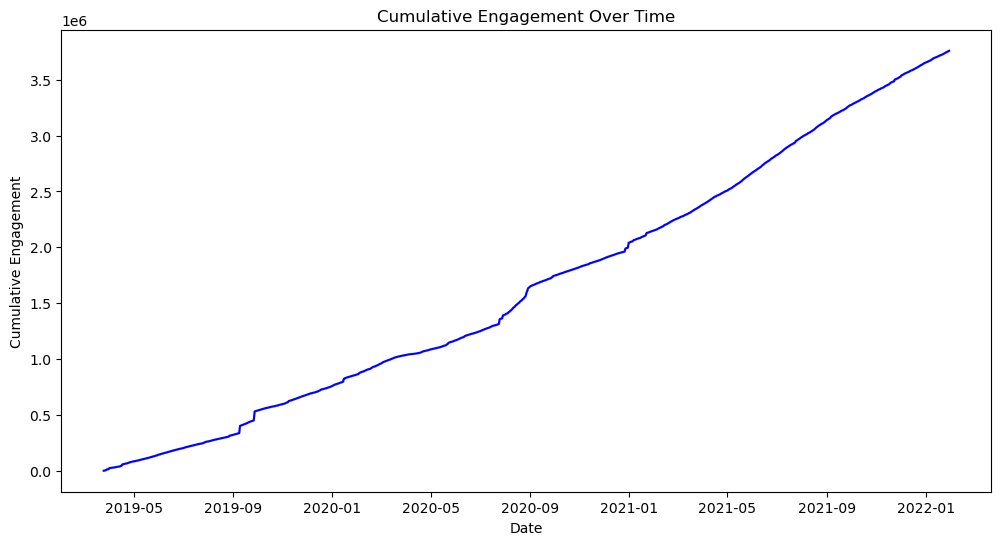

In [20]:
df_query_5['Date1'] = pd.to_datetime(df_query_5['Date1'])
plt.figure(figsize=(12, 6))
sns.lineplot(x="Date1", y="cumulative_engagement", data=df_query_5, color="blue")
plt.title("Cumulative Engagement Over Time")
plt.ylabel("Cumulative Engagement")
plt.xlabel("Date")
plt.show()

In [13]:
# Query 6: Average engagement by day type and time of day
query_6 = """
SELECT day_type, time_of_day, AVG(total_engagement) AS avg_engagement
FROM tweets_silver
GROUP BY day_type, time_of_day
ORDER BY avg_engagement DESC;
"""
df_query_6 = pd.read_sql_query(query_6, silver_connection)
print("Average engagement by day type and time of day:\n", df_query_6)

Average engagement by day type and time of day:
   day_type         time_of_day  avg_engagement
0  Weekday  Non-business hours      186.901917
1  Weekday      Business hours      145.814635


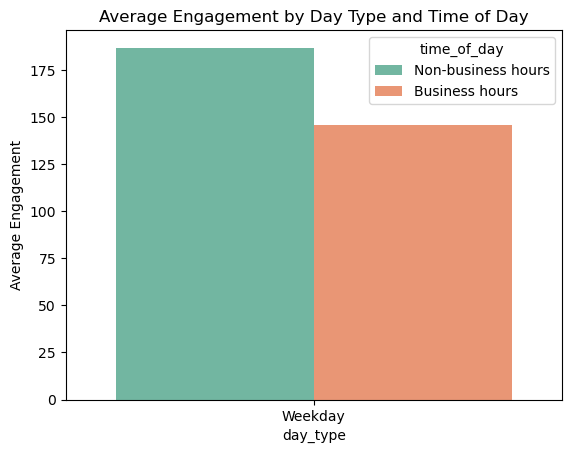

In [21]:
sns.barplot(x="day_type", y="avg_engagement", hue="time_of_day", data=df_query_6, palette="Set2")
plt.title("Average Engagement by Day Type and Time of Day")
plt.ylabel("Average Engagement")
plt.show()

In [14]:
# Query 7: Row number of tweets within each state by engagement level using ROW_NUMBER
query_7_row_number = """
SELECT State, conversation_id, total_engagement,
       ROW_NUMBER() OVER (PARTITION BY State ORDER BY total_engagement DESC) AS engagement_row
FROM tweets_silver
ORDER BY State, engagement_row;
"""
df_query_7_row_number = pd.read_sql_query(query_7_row_number, silver_connection)
print("Tweets row-numbered by engagement within each state (ROW_NUMBER):\n", df_query_7_row_number)


Tweets row-numbered by engagement within each state (ROW_NUMBER):
             State       conversation_id  total_engagement  engagement_row
0           Assam  S1222445088812367874               103               1
1           Assam  S1264915812365803521                76               2
2           Assam  S1223190227063164928                75               3
3           Assam  S1238457300299341824                62               4
4           Assam  S1223587137737478144                56               5
...           ...                   ...               ...             ...
23001  WestBengal  S1214139249890488320                 3             423
23002  WestBengal  S1227185511627808768                 3             424
23003  WestBengal  S1228279973120598016                 3             425
23004  WestBengal  S1228597312898752512                 3             426
23005  WestBengal  S1229322089355759618                 3             427

[23006 rows x 4 columns]


In [25]:
bronze_connection.close()

silver_connection.close()

gold_connection.close()